# IMAGE CLASSIFICATION USING CUSTOM CNN ARCHITECTURE

In [21]:

# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# CONFIGURATION AND DATA PATH SETUP

In [22]:


# Data path configuration
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Dataset"

# Configuration parameters
CONFIG = {
    'IMG_HEIGHT': 224,
    'IMG_WIDTH': 224,
    'BATCH_SIZE': 32,
    'EPOCHS': 10,
    'LEARNING_RATE': 0.001,
    'VALIDATION_SPLIT': 0.2,
    'TEST_SPLIT': 0.2,
    'RANDOM_STATE': 42,
    'NUM_CLASSES': 4
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['RANDOM_STATE'])
tf.random.set_seed(CONFIG['RANDOM_STATE'])

# Class names
CLASS_NAMES = ['Cloudy', 'Desert', 'Green Area', 'Water']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA EXPLORATION AND PREPROCESSING

In [23]:

def explore_dataset(data_path):
    """Explore dataset structure and class distribution"""
    print("="*60)
    print("DATASET EXPLORATION")
    print("="*60)

    class_counts = {}
    total_images = 0

    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total_images += count
            print(f"{class_name:12}: {count:,} images")
        else:
            print(f"Warning: {class_name} folder not found!")

    print(f"{'Total':12}: {total_images:,} images")

    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    bars = ax1.bar(class_counts.keys(), class_counts.values(),
                   color=['skyblue', 'sandybrown', 'lightgreen', 'lightcoral'])
    ax1.set_title('Class Distribution', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Number of Images', fontsize=12)
    ax1.set_xlabel('Classes', fontsize=12)

    # Add value labels on bars
    for bar, count in zip(bars, class_counts.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontweight='bold')

    # Pie chart
    colors = ['skyblue', 'sandybrown', 'lightgreen', 'lightcoral']
    wedges, texts, autotexts = ax2.pie(class_counts.values(), labels=class_counts.keys(),
                                      autopct='%1.1f%%', startangle=90, colors=colors)
    ax2.set_title('Class Distribution (Percentage)', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Check for class imbalance
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count

    print(f"\nClass Imbalance Analysis:")
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
    if imbalance_ratio > 2:
        print("⚠️  Significant class imbalance detected. Consider using class weights or oversampling.")
    else:
        print("✅ Classes are relatively balanced.")

    return class_counts, total_images

def create_data_generators(data_path, config):
    """Create data generators with augmentation"""
    print("\n" + "="*60)
    print("CREATING DATA GENERATORS")
    print("="*60)

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=config['VALIDATION_SPLIT']
    )

    # Only rescaling for validation and test
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=config['TEST_SPLIT']
    )

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=(config['IMG_HEIGHT'], config['IMG_WIDTH']),
        batch_size=config['BATCH_SIZE'],
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=config['RANDOM_STATE']
    )

    # Validation generator
    validation_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=(config['IMG_HEIGHT'], config['IMG_WIDTH']),
        batch_size=config['BATCH_SIZE'],
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=config['RANDOM_STATE']
    )

    # Test generator
    test_generator = test_datagen.flow_from_directory(
        data_path,
        target_size=(config['IMG_HEIGHT'], config['IMG_WIDTH']),
        batch_size=config['BATCH_SIZE'],
        class_mode='categorical',
        subset='training',  # Using training subset for test
        shuffle=False,
        seed=config['RANDOM_STATE']
    )

    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Class indices: {train_generator.class_indices}")

    return train_generator, validation_generator, test_generator

def visualize_sample_images(train_generator, class_names):
    """Visualize sample images from each class"""
    print("\n" + "="*60)
    print("SAMPLE IMAGES VISUALIZATION")
    print("="*60)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    # Get a batch of images
    batch_images, batch_labels = next(train_generator)

    for i in range(8):
        if i < len(batch_images):
            axes[i].imshow(batch_images[i])
            class_idx = np.argmax(batch_labels[i])
            axes[i].set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
            axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Sample Training Images with Augmentation', fontsize=16, fontweight='bold', y=1.02)
    plt.show()


# CUSTOM CNN MODEL ARCHITECTURE

In [24]:


def create_custom_cnn(input_shape, num_classes):
    """Create custom CNN with specified architecture"""
    print("\n" + "="*60)
    print("BUILDING CUSTOM CNN ARCHITECTURE")
    print("="*60)

    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), padding='same', name='conv1'),
        layers.BatchNormalization(name='bn1'),
        layers.ReLU(name='relu1'),
        layers.MaxPooling2D((2, 2), name='maxpool1'),
        layers.Dropout(0.25, name='dropout1'),

        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), padding='same', name='conv2'),
        layers.BatchNormalization(name='bn2'),
        layers.ReLU(name='relu2'),
        layers.MaxPooling2D((2, 2), name='maxpool2'),
        layers.Dropout(0.25, name='dropout2'),

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), padding='same', name='conv3'),
        layers.BatchNormalization(name='bn3'),
        layers.ReLU(name='relu3'),
        layers.MaxPooling2D((2, 2), name='maxpool3'),
        layers.Dropout(0.25, name='dropout3'),

        # Classification Block
        layers.Flatten(name='flatten'),
        layers.Dropout(0.5, name='dropout4'),

        # Fully Connected Layer 1
        layers.Dense(512, name='fc1'),
        layers.BatchNormalization(name='bn4'),
        layers.ReLU(name='relu4'),
        layers.Dropout(0.5, name='dropout5'),

        # Fully Connected Layer 2
        layers.Dense(256, name='fc2'),
        layers.BatchNormalization(name='bn5'),
        layers.ReLU(name='relu5'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

def compile_model(model, learning_rate):
    """Compile the model with optimizer, loss, and metrics"""
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

def display_model_architecture(model):
    """Display detailed model architecture"""
    print("\nMODEL ARCHITECTURE SUMMARY:")
    print("-" * 50)
    model.summary()

    # Calculate total parameters
    total_params = model.count_params()
    print(f"\nTotal Parameters: {total_params:,}")



    # Visualize model architecture (compact version)
    tf.keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=False,  # Hide shapes to reduce size
    show_layer_names=False,  # Hide layer names to reduce size
    rankdir='LR',  # Horizontal layout
    dpi=150  # Lower DPI for smaller file
    )

    from IPython.display import Image, display
    display(Image('model_architecture.png', width=600))  # Fixed width


# MODEL TRAINING AND CALLBACKS

In [25]:


def create_callbacks():
    """Create training callbacks"""
    callbacks_list = [
        # Early stopping
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),

        # Learning rate reduction
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),

        # Model checkpoint
        callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

    return callbacks_list

def train_model(model, train_gen, val_gen, epochs, callbacks_list):
    """Train the model"""
    print("\n" + "="*60)
    print("STARTING MODEL TRAINING")
    print("="*60)

    # Calculate steps
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Train the model
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks_list,
        verbose=1
    )

    return history


# MODEL EVALUATION AND VISUALIZATION

In [26]:


def plot_training_history(history):
    """Plot comprehensive training history"""
    print("\n" + "="*60)
    print("TRAINING HISTORY VISUALIZATION")
    print("="*60)

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
    axes[0, 0].plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[0, 0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=6)
    axes[0, 1].plot(history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=6)
    axes[0, 1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], 'go-', label='Training Precision', linewidth=2, markersize=6)
        axes[1, 0].plot(history.history['val_precision'], 'mo-', label='Validation Precision', linewidth=2, markersize=6)
        axes[1, 0].set_title('Model Precision Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Plot recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], 'co-', label='Training Recall', linewidth=2, markersize=6)
        axes[1, 1].plot(history.history['val_recall'], 'yo-', label='Validation Recall', linewidth=2, markersize=6)
        axes[1, 1].set_title('Model Recall Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"\nFINAL TRAINING METRICS:")
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")

def evaluate_model_comprehensive(model, test_generator, class_names):
    """Comprehensive model evaluation"""
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Reset test generator
    test_generator.reset()

    # Get predictions
    steps = test_generator.samples // test_generator.batch_size + 1
    predictions = model.predict(test_generator, steps=steps, verbose=1)

    # Get true labels
    true_labels = test_generator.classes[:len(predictions)]
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate metrics - FIX: Handle multiple metrics returned by evaluate
    evaluation_results = model.evaluate(test_generator, steps=steps, verbose=0)

    # Since model was compiled with ['accuracy', 'precision', 'recall'],
    # evaluate returns [loss, accuracy, precision, recall]
    test_loss = evaluation_results[0]
    test_accuracy = evaluation_results[1]
    # test_precision = evaluation_results[2]  # Available if needed
    # test_recall = evaluation_results[3]     # Available if needed

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Classification report
    report = classification_report(true_labels, predicted_labels,
                                 target_names=class_names, output_dict=True)

    print("\nDETAILED CLASSIFICATION REPORT:")
    print("-" * 50)
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    return true_labels, predicted_labels, predictions, report

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    """Plot enhanced confusion matrix"""
    print("\n" + "="*60)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*60)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Confusion matrix (counts)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1,
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Predicted Labels', fontsize=12)
    ax1.set_ylabel('True Labels', fontsize=12)

    # Confusion matrix (percentages)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=ax2,
                cbar_kws={'label': 'Percentage (%)'})
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Predicted Labels', fontsize=12)
    ax2.set_ylabel('True Labels', fontsize=12)

    plt.tight_layout()
    plt.show()

    return cm

def calculate_detailed_metrics(true_labels, predicted_labels, class_names):
    """Calculate detailed performance metrics"""
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE METRICS")
    print("="*60)

    # Calculate precision, recall, f1-score for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, labels=range(len(class_names))
    )

    # Calculate specificity for each class
    cm = confusion_matrix(true_labels, predicted_labels)
    specificity = []

    for i in range(len(class_names)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    # Create detailed metrics DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Support': support
    })

    # Calculate macro and weighted averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_specificity = np.mean(specificity)
    macro_f1 = np.mean(f1)

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_specificity = np.average(specificity, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    # Add summary rows
    summary_df = pd.DataFrame({
        'Class': ['Macro Average', 'Weighted Average'],
        'Precision': [macro_precision, weighted_precision],
        'Recall (Sensitivity)': [macro_recall, weighted_recall],
        'Specificity': [macro_specificity, weighted_specificity],
        'F1-Score': [macro_f1, weighted_f1],
        'Support': [np.sum(support), np.sum(support)]
    })

    full_metrics_df = pd.concat([metrics_df, summary_df], ignore_index=True)

    # Display the metrics table
    print("\nPERFORMANCE METRICS TABLE:")
    print("-" * 80)
    print(full_metrics_df.round(4).to_string(index=False))

    # Visualize metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Precision by class
    bars1 = axes[0, 0].bar(class_names, precision, color='skyblue', alpha=0.8)
    axes[0, 0].set_title('Precision by Class', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].set_ylim(0, 1)
    for bar, val in zip(bars1, precision):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    # Recall (Sensitivity) by class
    bars2 = axes[0, 1].bar(class_names, recall, color='lightgreen', alpha=0.8)
    axes[0, 1].set_title('Recall (Sensitivity) by Class', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_ylim(0, 1)
    for bar, val in zip(bars2, recall):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    # Specificity by class
    bars3 = axes[1, 0].bar(class_names, specificity, color='lightcoral', alpha=0.8)
    axes[1, 0].set_title('Specificity by Class', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Specificity')
    axes[1, 0].set_ylim(0, 1)
    for bar, val in zip(bars3, specificity):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    # F1-Score by class
    bars4 = axes[1, 1].bar(class_names, f1, color='gold', alpha=0.8)
    axes[1, 1].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_ylim(0, 1)
    for bar, val in zip(bars4, f1):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return full_metrics_df

def plot_prediction_confidence(predictions, true_labels, predicted_labels, class_names):
    """Plot prediction confidence analysis"""
    print("\n" + "="*60)
    print("PREDICTION CONFIDENCE ANALYSIS")
    print("="*60)

    # Calculate confidence scores
    confidence_scores = np.max(predictions, axis=1)
    correct_predictions = (true_labels == predicted_labels)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Confidence distribution
    axes[0, 0].hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(np.mean(confidence_scores), color='red', linestyle='--',
                      label=f'Mean: {np.mean(confidence_scores):.3f}')
    axes[0, 0].legend()

    # Confidence vs Accuracy
    axes[0, 1].scatter(confidence_scores[correct_predictions],
                      np.ones(np.sum(correct_predictions)),
                      alpha=0.6, color='green', label='Correct', s=20)
    axes[0, 1].scatter(confidence_scores[~correct_predictions],
                      np.zeros(np.sum(~correct_predictions)),
                      alpha=0.6, color='red', label='Incorrect', s=20)
    axes[0, 1].set_title('Confidence vs Prediction Correctness', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Prediction Correctness')
    axes[0, 1].set_yticks([0, 1])
    axes[0, 1].set_yticklabels(['Incorrect', 'Correct'])
    axes[0, 1].legend()

    # Confidence by class
    conf_by_class = []
    for i, class_name in enumerate(class_names):
        class_mask = predicted_labels == i
        if np.any(class_mask):
            conf_by_class.append(confidence_scores[class_mask])
        else:
            conf_by_class.append([])

    axes[1, 0].boxplot(conf_by_class, labels=class_names)
    axes[1, 0].set_title('Confidence Distribution by Predicted Class', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Confidence Score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Accuracy vs Confidence bins
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins)-1):
        mask = (confidence_scores >= confidence_bins[i]) & (confidence_scores < confidence_bins[i+1])
        if np.any(mask):
            accuracy = np.mean(correct_predictions[mask])
            bin_accuracies.append(accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

    axes[1, 1].plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=8)
    axes[1, 1].plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect Calibration')
    axes[1, 1].set_title('Calibration Curve', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Mean Predicted Confidence')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
def generate_final_report(model, history, metrics_df, test_accuracy, test_loss):
    """Generate comprehensive final report"""
    print("\n" + "="*80)
    print("FINAL MODEL PERFORMANCE REPORT")
    print("="*80)

    # Model summary
    print("\n📊 MODEL ARCHITECTURE SUMMARY:")
    print("-" * 50)
    print(f"Total Parameters: {model.count_params():,}")
    print(f"Model Input Shape: {model.input_shape}")
    print(f"Model Output Shape: {model.output_shape}")

    # Training summary
    print("\n🎯 TRAINING PERFORMANCE:")
    print("-" * 50)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    # Test performance
    print("\n🧪 TEST PERFORMANCE:")
    print("-" * 50)
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Loss: {test_loss:.4f}")

    # Best metrics per class
    print("\n🏆 BEST PERFORMING CLASSES:")
    print("-" * 50)
    class_metrics = metrics_df[metrics_df['Class'].isin(['Cloudy', 'Desert', 'Green Area', 'Water'])]

    if not class_metrics.empty:
        best_precision = class_metrics.loc[class_metrics['Precision'].idxmax()]
        best_recall = class_metrics.loc[class_metrics['Recall (Sensitivity)'].idxmax()]
        best_f1 = class_metrics.loc[class_metrics['F1-Score'].idxmax()]

        print(f"Highest Precision: {best_precision['Class']} ({best_precision['Precision']:.4f})")
        print(f"Highest Recall: {best_recall['Class']} ({best_recall['Recall (Sensitivity)']:.4f})")
        print(f"Highest F1-Score: {best_f1['Class']} ({best_f1['F1-Score']:.4f})")

    # Overall assessment
    print("\n📈 OVERALL ASSESSMENT:")
    print("-" * 50)
    overfitting_indicator = abs(final_train_acc - final_val_acc)

    if overfitting_indicator < 0.05:
        print("✅ Model shows good generalization (low overfitting)")
    elif overfitting_indicator < 0.10:
        print("⚠️  Model shows moderate overfitting")
    else:
        print("❌ Model shows significant overfitting")

    if test_accuracy > 0.90:
        print("🎉 Excellent model performance!")
    elif test_accuracy > 0.80:
        print("👍 Good model performance")
    elif test_accuracy > 0.70:
        print("👌 Fair model performance")
    else:
        print("📉 Model needs improvement")

    # Recommendations
    print("\n💡 RECOMMENDATIONS:")
    print("-" * 50)
    if overfitting_indicator > 0.10:
        print("• Consider increasing dropout rates")
        print("• Add more data augmentation")
        print("• Reduce model complexity")

    if test_accuracy < 0.80:
        print("• Try different optimizers (SGD, RMSprop)")
        print("• Experiment with learning rate scheduling")
        print("• Consider transfer learning")
        print("• Increase training epochs with early stopping")

    macro_avg_row = metrics_df[metrics_df['Class'] == 'Macro Average']
    if not macro_avg_row.empty:
        macro_f1 = macro_avg_row['F1-Score'].iloc[0]
        if macro_f1 < 0.75:
            print("• Address class imbalance with weighted loss")
            print("• Consider ensemble methods")


# MAIN EXECUTION PIPELINE


In [27]:


def main():
    """Main execution pipeline"""
    print("🚀 STARTING IMAGE CLASSIFICATION PIPELINE")
    print("="*80)

    try:
        # Step 1: Explore dataset
        class_counts, total_images = explore_dataset(DATA_PATH)

        # Step 2: Create data generators
        train_gen, val_gen, test_gen = create_data_generators(DATA_PATH, CONFIG)

        # Step 3: Visualize sample images
        visualize_sample_images(train_gen, CLASS_NAMES)

        # Step 4: Create and compile model
        input_shape = (CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'], 3)
        model = create_custom_cnn(input_shape, CONFIG['NUM_CLASSES'])
        model = compile_model(model, CONFIG['LEARNING_RATE'])

        # Step 5: Display model architecture
        display_model_architecture(model)

        # Step 6: Create callbacks
        callbacks_list = create_callbacks()

        # Step 7: Train model
        history = train_model(model, train_gen, val_gen, CONFIG['EPOCHS'], callbacks_list)

        # Step 8: Plot training history
        plot_training_history(history)

        # Step 9: Comprehensive evaluation
        true_labels, predicted_labels, predictions, report = evaluate_model_comprehensive(
            model, test_gen, CLASS_NAMES
        )

        # Step 10: Plot confusion matrix
        cm = plot_confusion_matrix(true_labels, predicted_labels, CLASS_NAMES)

        # Step 11: Calculate detailed metrics
        metrics_df = calculate_detailed_metrics(true_labels, predicted_labels, CLASS_NAMES)

        # Step 12: Prediction confidence analysis
        plot_prediction_confidence(predictions, true_labels, predicted_labels, CLASS_NAMES)

        # Step 13: Generate final report - FIX: Get test metrics properly
        evaluation_results = model.evaluate(test_gen, verbose=0)
        test_loss = evaluation_results[0]
        test_accuracy = evaluation_results[1]

        generate_final_report(model, history, metrics_df, test_accuracy, test_loss)

        # Step 14: Save model
        model.save('final_custom_cnn_model.h5')
        print(f"\n💾 Model saved as 'final_custom_cnn_model.h5'")

        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*80)

        return model, history, metrics_df

    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        print("Please check your data path and ensure all required folders exist.")
        import traceback
        traceback.print_exc()  # This will show the full error traceback
        raise


# ADDITIONAL UTILITY FUNCTIONS

In [28]:


def predict_single_image(model, image_path, class_names):
    """Predict a single image"""
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = model.predict(img, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        confidence = prediction[0][predicted_class_idx]

        # Display results
        plt.figure(figsize=(10, 4))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(img[0])
        plt.title(f'Input Image', fontsize=14, fontweight='bold')
        plt.axis('off')

        # Show prediction probabilities
        plt.subplot(1, 2, 2)
        bars = plt.bar(class_names, prediction[0], color=['skyblue', 'sandybrown', 'lightgreen', 'lightcoral'])
        plt.title(f'Prediction: {class_names[predicted_class_idx]} (Confidence: {confidence:.3f})',
                 fontsize=14, fontweight='bold')
        plt.ylabel('Probability')
        plt.xticks(rotation=45)

        # Highlight predicted class
        bars[predicted_class_idx].set_color('red')
        bars[predicted_class_idx].set_alpha(0.8)

        plt.tight_layout()
        plt.show()

        return class_names[predicted_class_idx], confidence

    except Exception as e:
        print(f"Error predicting image: {str(e)}")
        return None, None

def create_model_comparison_report(models_dict):
    """Compare multiple models"""
    if len(models_dict) < 2:
        print("Need at least 2 models for comparison")
        return

    print("\n" + "="*60)
    print("MODEL COMPARISON REPORT")
    print("="*60)

    comparison_data = []

    for model_name, (model, history, test_acc) in models_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Parameters': model.count_params(),
            'Final Train Acc': history.history['accuracy'][-1],
            'Final Val Acc': history.history['val_accuracy'][-1],
            'Test Accuracy': test_acc,
            'Best Val Acc': max(history.history['val_accuracy'])
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(4).to_string(index=False))

    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Test accuracy comparison
    bars1 = axes[0, 0].bar(comparison_df['Model'], comparison_df['Test Accuracy'],
                          color='skyblue', alpha=0.8)
    axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Test Accuracy')
    for bar, val in zip(bars1, comparison_df['Test Accuracy']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    # Parameters comparison
    bars2 = axes[0, 1].bar(comparison_df['Model'], comparison_df['Parameters'],
                          color='lightgreen', alpha=0.8)
    axes[0, 1].set_title('Model Complexity (Parameters)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Parameters')
    for bar, val in zip(bars2, comparison_df['Parameters']):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                       f'{val:,}', ha='center', va='bottom', fontweight='bold', rotation=45)

    # Training vs Validation accuracy
    x = np.arange(len(comparison_df))
    width = 0.35
    axes[1, 0].bar(x - width/2, comparison_df['Final Train Acc'], width,
                   label='Training', color='orange', alpha=0.8)
    axes[1, 0].bar(x + width/2, comparison_df['Final Val Acc'], width,
                   label='Validation', color='red', alpha=0.8)
    axes[1, 0].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(comparison_df['Model'])
    axes[1, 0].legend()

    # Overfitting analysis
    overfitting = comparison_df['Final Train Acc'] - comparison_df['Final Val Acc']
    bars4 = axes[1, 1].bar(comparison_df['Model'], overfitting,
                          color=['green' if x < 0.05 else 'orange' if x < 0.10 else 'red' for x in overfitting],
                          alpha=0.8)
    axes[1, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Train Acc - Val Acc')
    axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Warning Level')
    axes[1, 1].axhline(y=0.10, color='red', linestyle='--', alpha=0.7, label='High Overfitting')
    axes[1, 1].legend()

    for bar, val in zip(bars4, overfitting):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


# EXECUTE MAIN PIPELINE

🚀 STARTING IMAGE CLASSIFICATION PIPELINE
DATASET EXPLORATION
Cloudy      : 476 images
Desert      : 489 images
Green Area  : 490 images
Water       : 297 images
Total       : 1,752 images


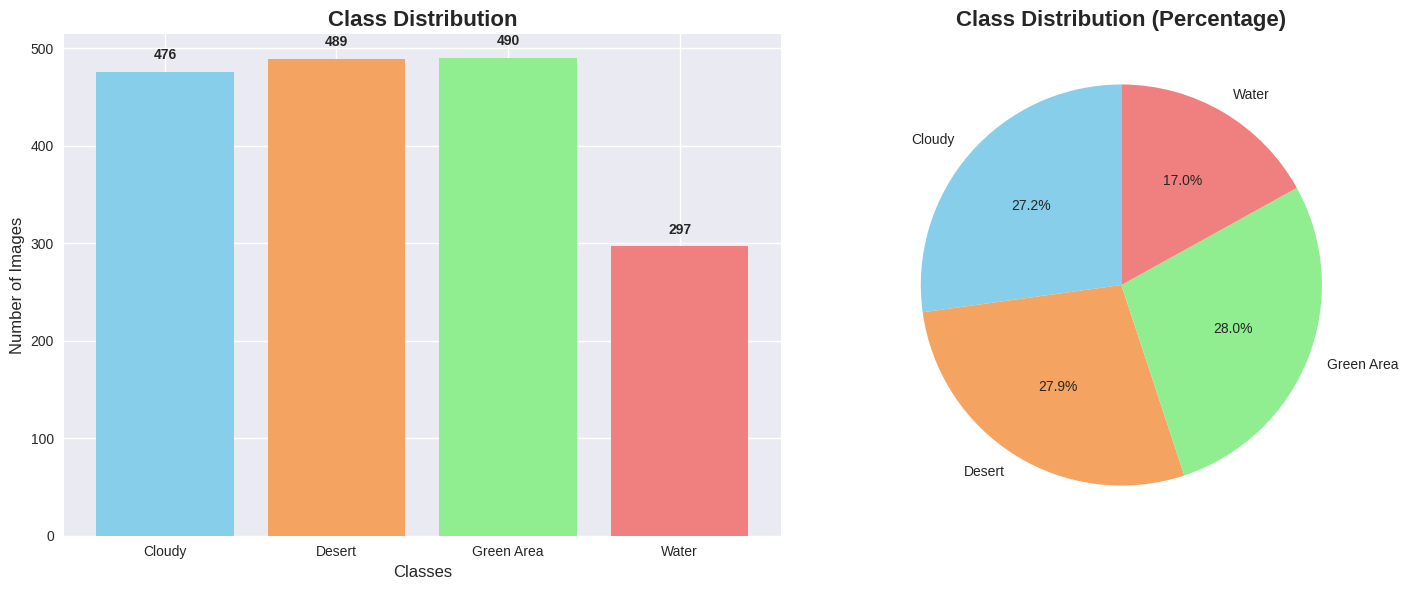


Class Imbalance Analysis:
Imbalance Ratio: 1.65
✅ Classes are relatively balanced.

CREATING DATA GENERATORS
Found 1403 images belonging to 4 classes.
Found 349 images belonging to 4 classes.
Found 1403 images belonging to 4 classes.
Training samples: 1403
Validation samples: 349
Test samples: 1403
Class indices: {'Cloudy': 0, 'Desert': 1, 'Green Area': 2, 'Water': 3}

SAMPLE IMAGES VISUALIZATION


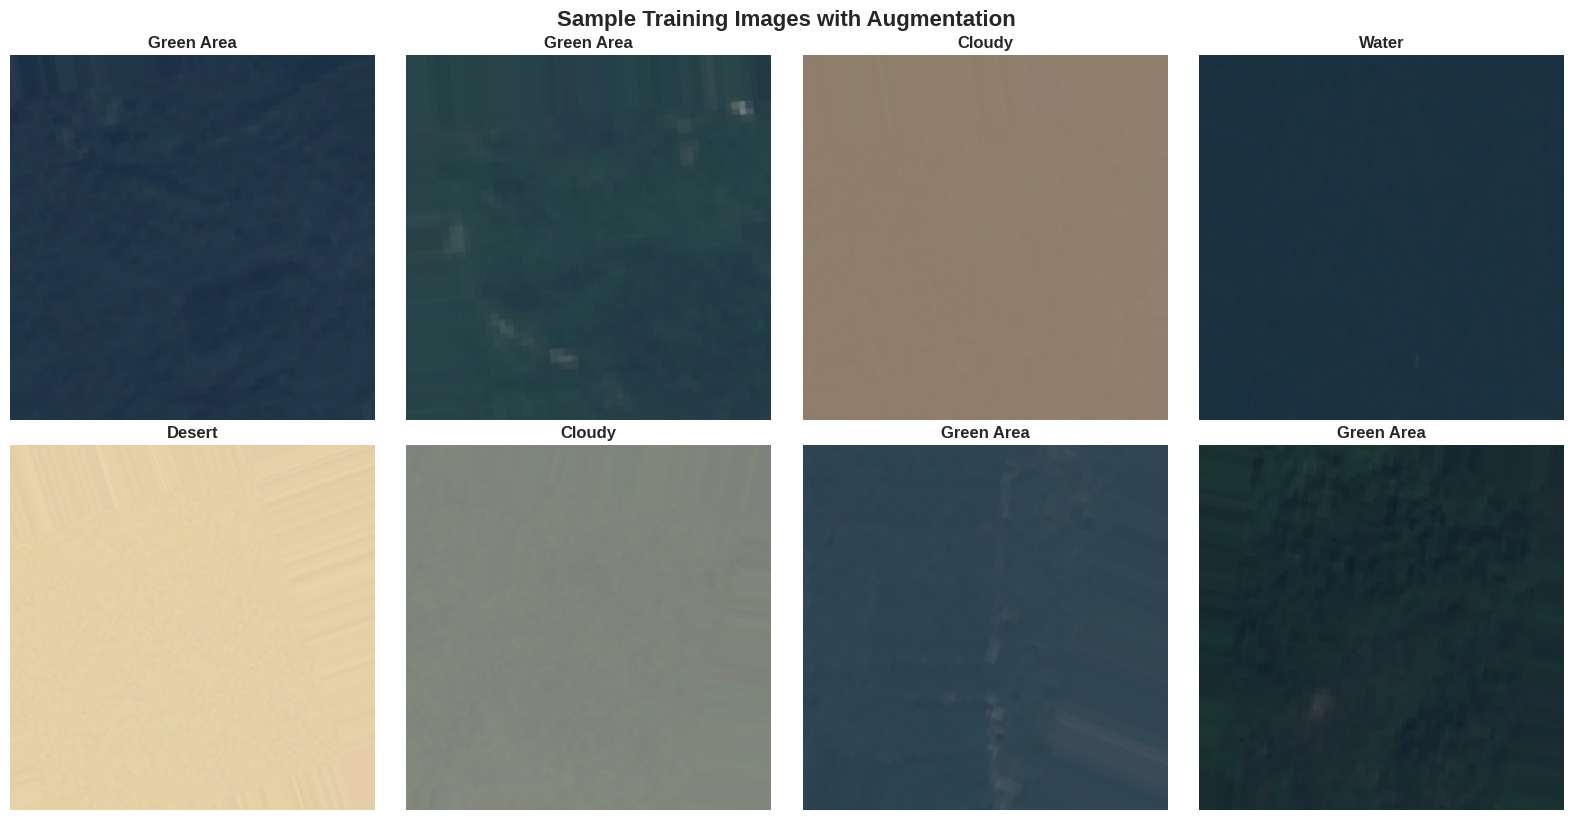


BUILDING CUSTOM CNN ARCHITECTURE

MODEL ARCHITECTURE SUMMARY:
--------------------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,02

 Total params: 51,610,308 (196.88 MB)

 Trainable params: 51,608,324 (196.87 MB)

 Non-trainable params: 1,984 (7.75 KB)


Total Parameters: 51,610,308


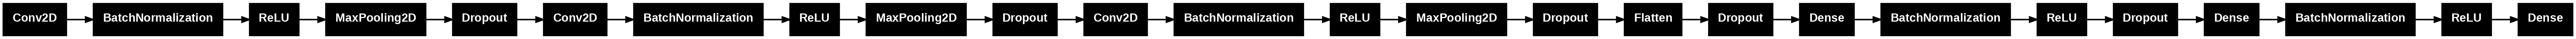


STARTING MODEL TRAINING
Steps per epoch: 43
Validation steps: 10
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.6687 - loss: 0.7736 - precision: 0.7010 - recall: 0.6255
Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to best_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 976ms/step - accuracy: 0.6699 - loss: 0.7705 - precision: 0.7019 - recall: 0.6271 - val_accuracy: 0.2750 - val_loss: 1.6617 - val_precision: 0.2744 - val_recall: 0.2719 - learning_rate: 0.0010
Epoch 2/10
 1/43 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7500 - loss: 0.5205 - precision: 0.7742 - recall: 0.7500
Epoch 2: val_accuracy improved from 0.27500 to 0.28125, saving model to best_model.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - accuracy: 0.7500 - loss: 0.5205 - precision: 0.7742 - recall: 0.7500 - val_accuracy: 0.2812 - val_loss: 1.7268 - val_precision: 0.2812 - val_recall: 0.2812 - learning_rate: 0.0010
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8052 - loss: 0.4862 - precision: 0.8077 - recall: 0.8006
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.28125
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8055 - loss: 0.4857 - precision: 0.8080 - recall: 0.8008 - val_accuracy: 0.2656 - val_loss: 2.7733 - val_precision: 0.2656 - val_recall: 0.2656 - learning_rate: 0.0010
Epoch 4/10
 1/43 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8750 - loss: 0.4234 - precision: 0.8750 - recall: 0.8750
Epoch 4: val_accuracy did not improve from 0.28125
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8750 - loss: 0.4234 - precision: 0.8750 - recall: 0.8750 - val_accuracy: 0.2

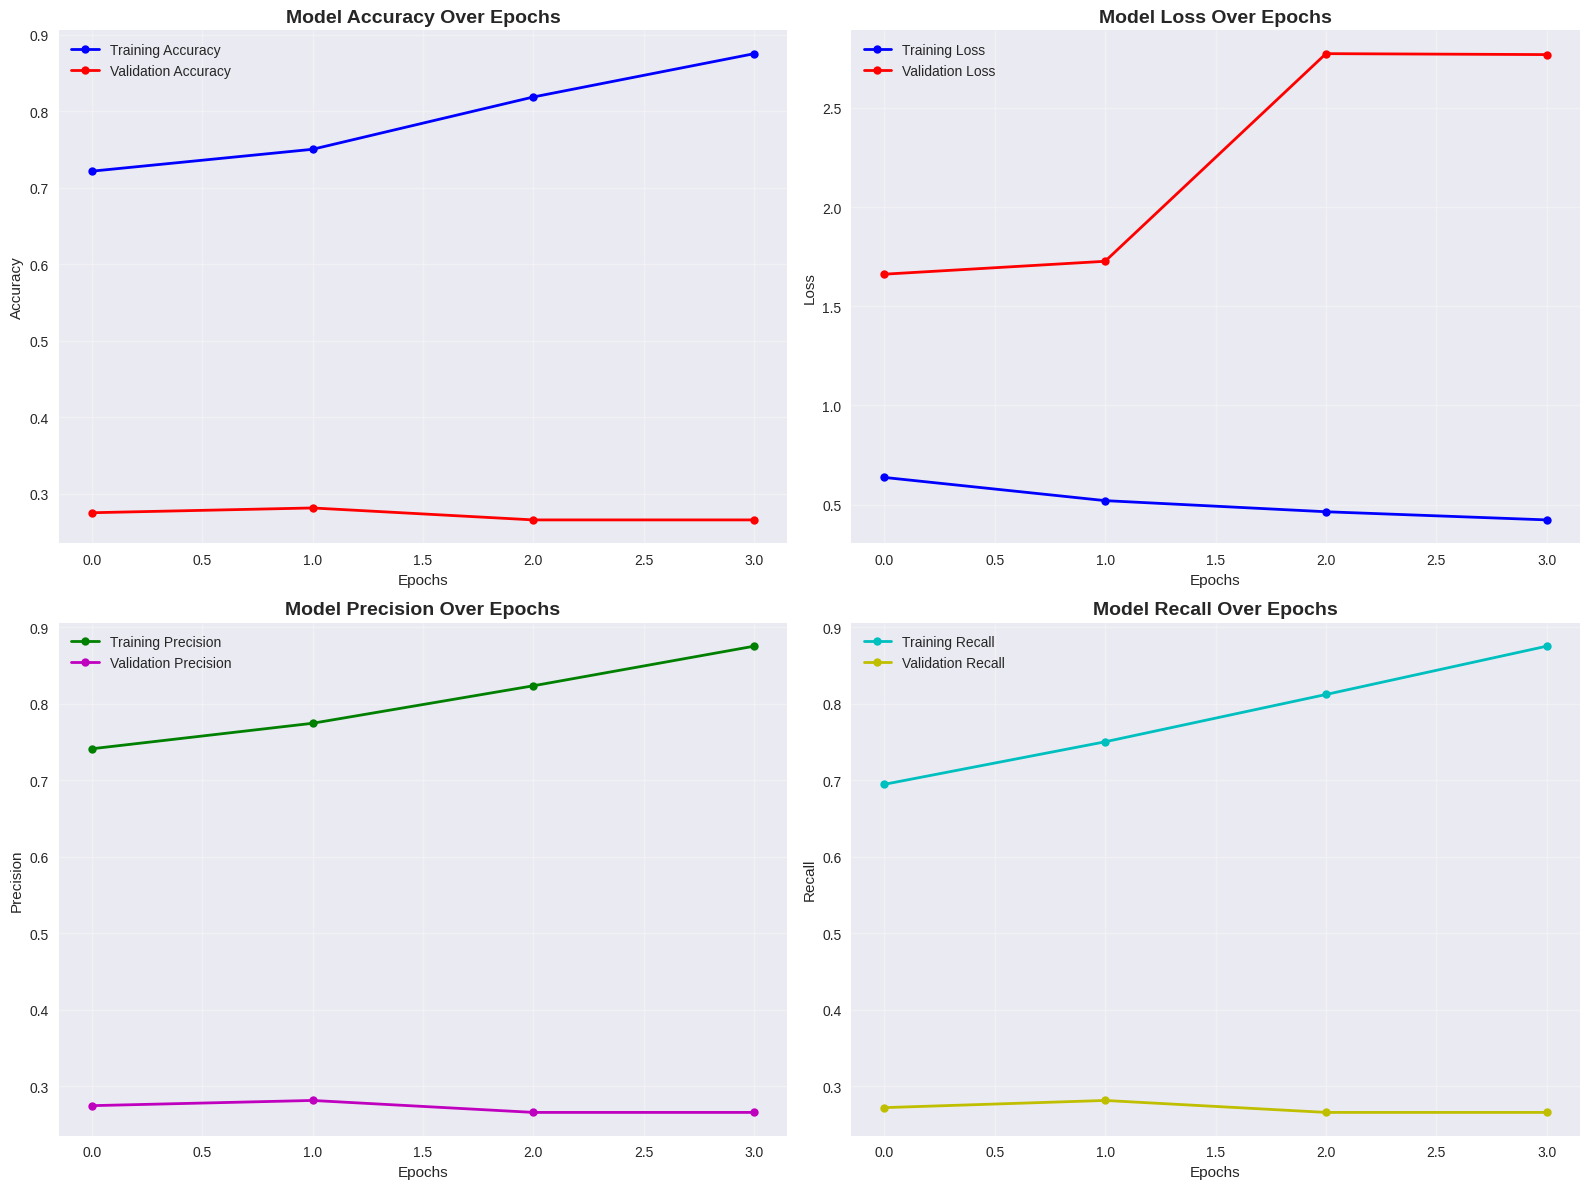


FINAL TRAINING METRICS:
Training Accuracy: 0.8750
Validation Accuracy: 0.2656
Training Loss: 0.4234
Validation Loss: 2.7685

COMPREHENSIVE MODEL EVALUATION
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step
Test Accuracy: 0.2716
Test Loss: 1.6411

DETAILED CLASSIFICATION REPORT:
--------------------------------------------------
              precision    recall  f1-score   support

      Cloudy       0.27      1.00      0.43       381
      Desert       0.00      0.00      0.00       392
  Green Area       0.00      0.00      0.00       392
       Water       0.00      0.00      0.00       238

    accuracy                           0.27      1403
   macro avg       0.07      0.25      0.11      1403
weighted avg       0.07      0.27      0.12      1403


CONFUSION MATRIX ANALYSIS


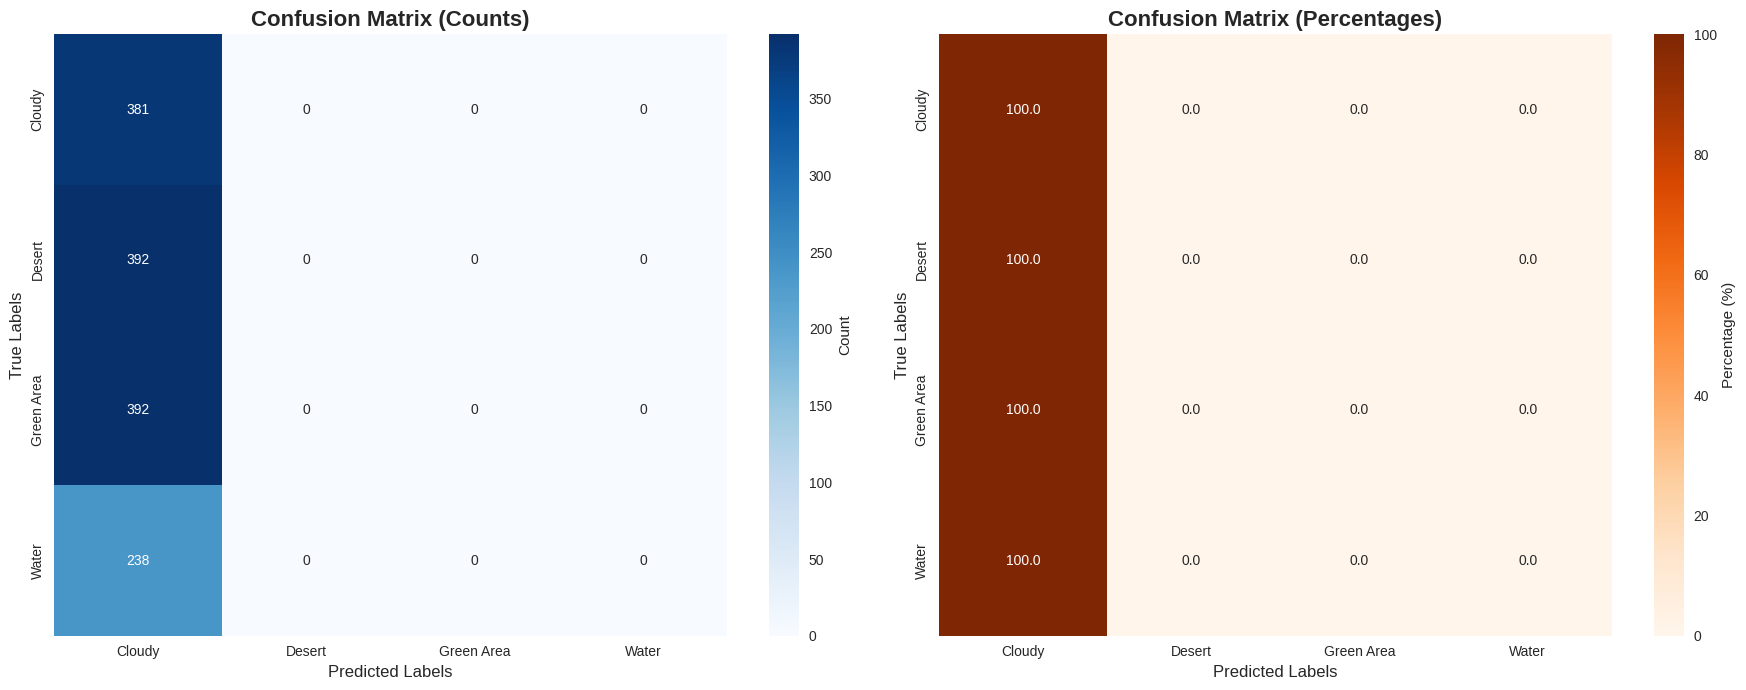


DETAILED PERFORMANCE METRICS

PERFORMANCE METRICS TABLE:
--------------------------------------------------------------------------------
           Class  Precision  Recall (Sensitivity)  Specificity  F1-Score  Support
          Cloudy     0.2716                1.0000       0.0000    0.4271      381
          Desert     0.0000                0.0000       1.0000    0.0000      392
      Green Area     0.0000                0.0000       1.0000    0.0000      392
           Water     0.0000                0.0000       1.0000    0.0000      238
   Macro Average     0.0679                0.2500       0.7500    0.1068     1403
Weighted Average     0.0737                0.2716       0.7284    0.1160     1403


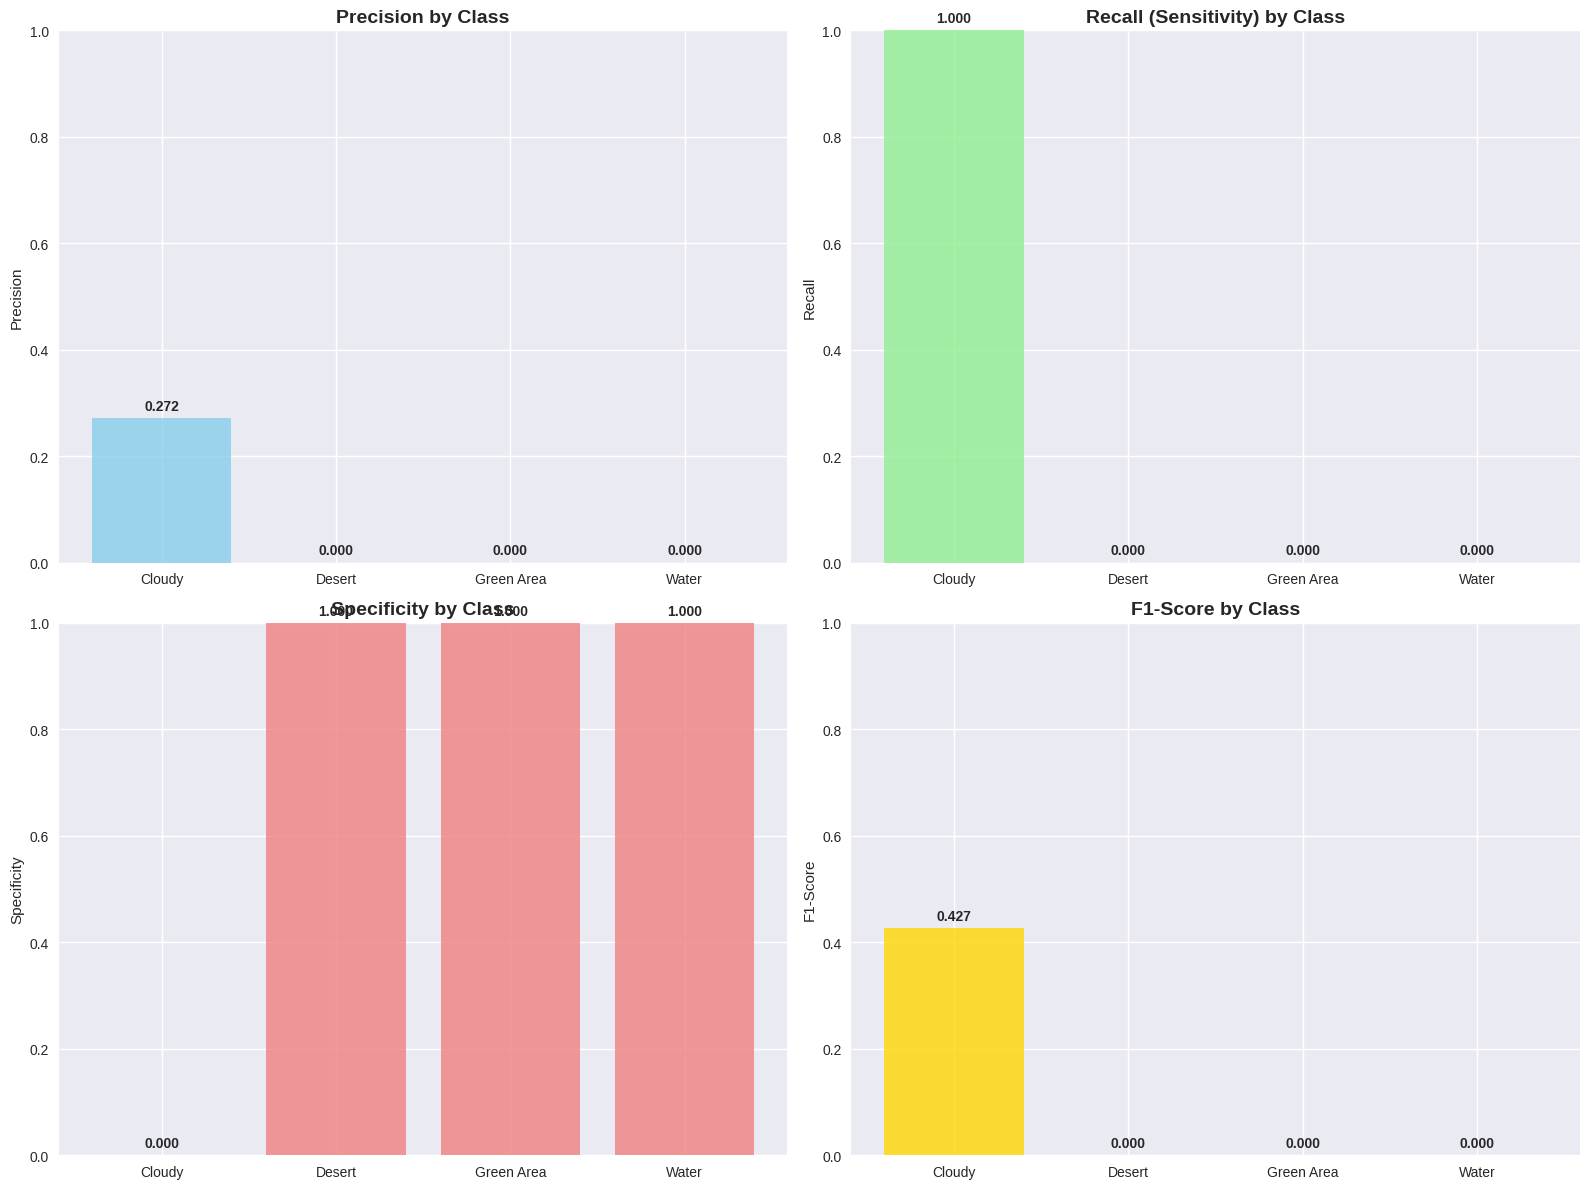


PREDICTION CONFIDENCE ANALYSIS


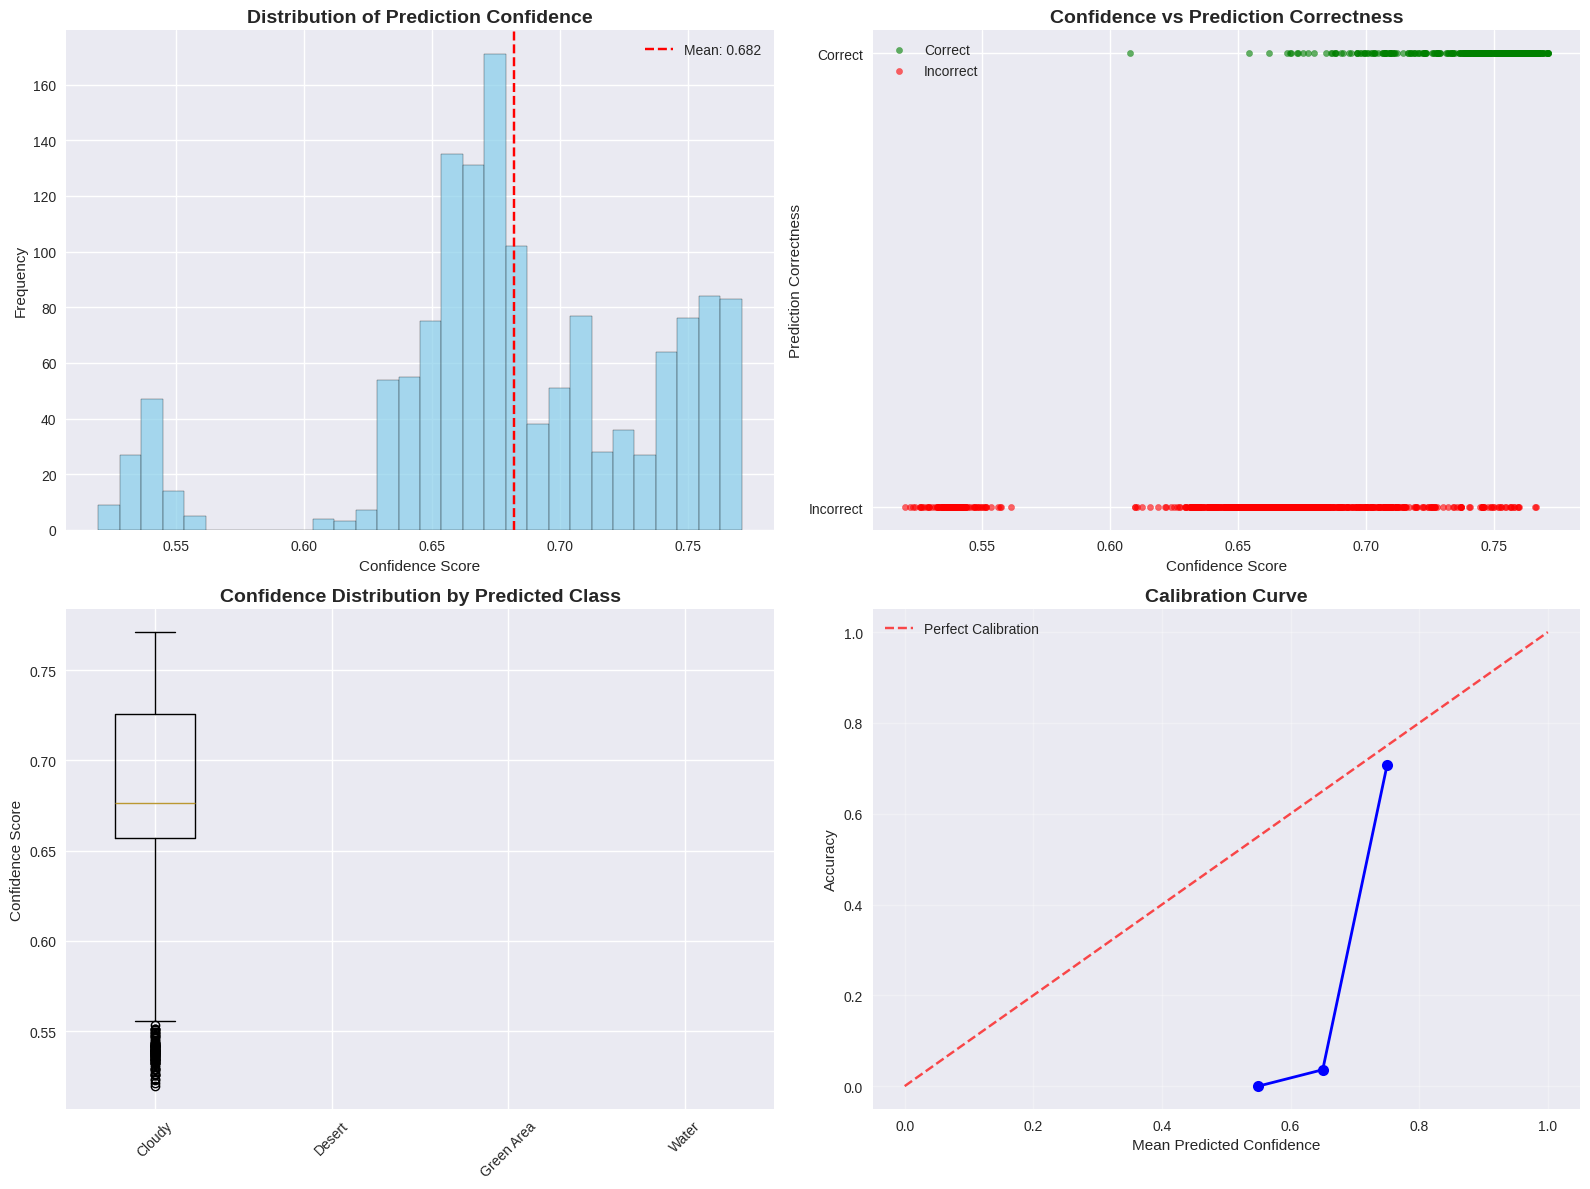


FINAL MODEL PERFORMANCE REPORT

📊 MODEL ARCHITECTURE SUMMARY:
--------------------------------------------------
Total Parameters: 51,610,308
Model Input Shape: (None, 224, 224, 3)
Model Output Shape: (None, 4)

🎯 TRAINING PERFORMANCE:
--------------------------------------------------
Final Training Accuracy: 0.8750 (87.50%)
Final Validation Accuracy: 0.2656 (26.56%)
Final Training Loss: 0.4234
Final Validation Loss: 2.7685

🧪 TEST PERFORMANCE:
--------------------------------------------------
Test Accuracy: 0.2716 (27.16%)
Test Loss: 1.6411

🏆 BEST PERFORMING CLASSES:
--------------------------------------------------
Highest Precision: Cloudy (0.2716)
Highest Recall: Cloudy (1.0000)
Highest F1-Score: Cloudy (0.4271)

📈 OVERALL ASSESSMENT:
--------------------------------------------------
❌ Model shows significant overfitting
📉 Model needs improvement

💡 RECOMMENDATIONS:
--------------------------------------------------
• Consider increasing dropout rates
• Add more data augmenta

In [29]:


if __name__ == "__main__":
    # Run the main pipeline
    model, history, metrics_df = main()

    # Example of single image prediction (uncomment to use)
    # predicted_class, confidence = predict_single_image(model, 'path_to_your_image.jpg', CLASS_NAMES)
    # print(f"Predicted: {predicted_class} with confidence: {confidence:.3f}")

print("\n🎯 SCRIPT READY FOR EXECUTION!")
print("="*60)
print("To run the complete pipeline, execute: main()")
print("To predict a single image, use: predict_single_image(model, image_path, CLASS_NAMES)")
print("="*60)